<a href="https://colab.research.google.com/github/cutemfc/Time_series_project/blob/main/LSTM_model_hyperparameters_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import google colab
import google.colab as colab
colab.drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [20]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00


In [21]:
import mlflow.tensorflow
from mlflow.models.signature import infer_signature

# Step 1: Load the data

In [3]:
# read file to analysis
df_filled=pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/df_filled.csv')

In [4]:
df_train=df_filled.copy()
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [5]:
# Filter the data before 2014-04-01
max_date = '2014-04-01'
df_train = df_train[df_train['date'] < max_date]
df_train.head()
df_train.shape

(9437752, 6)

In [6]:
## Groupby by 'date' and aggregate 'unit_sales' by sum
df_train = df_train.groupby('date')['unit_sales'].sum().reset_index()

In [7]:
df_train.head()

,date,unit_sales
0,2013-01-02,42320.0
1,2013-01-03,32708.0
2,2013-01-04,30849.0
3,2013-01-05,42351.0
4,2013-01-06,43988.0


# Step 2: Preprocessing the Data for LSTM

In [8]:
# preprocesing the data for LSTM
# Normalize the data using Min_max scaling
scaler = MinMaxScaler(feature_range=(0,1))
df_train['unit_sales'] = scaler.fit_transform(df_train[['unit_sales']])# double bracket is 2D for the MinMaxScaler

In [9]:
# Create sequence of data for LSM
def create_sequence(data, seq_length):
  X = []
  y = []
  for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
  return np.array(X),np.array(y)

In [10]:
# set sequence length(e.g past 90 days of sales)
seq_length =90
# Create sequence
data= df_train['unit_sales'].values # values turn to 1D numpy array
X,y = create_sequence(data,seq_length) # create_sequence split X and y

In [11]:
# Split into training and testing sets
train_size=int(len(X)*0.8)
X_train,X_test=X[:train_size],X[train_size:]
y_train,y_test=y[:train_size],y[train_size:]

In [12]:
# Reshape for LSTM, it need 3D data
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
#

# step 3: Build the model

In [13]:
# Build and Training the LSTM Model
model=Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length,1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 2 LSTM layers and 50 units

In [22]:
# Start MLflow run
with mlflow.start_run(run_name="LSTM_store_item_features_run"):
    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")

Run ID: ad8f9ce43e82479584db471d4a88a66f


In [24]:
# Log model parameters
mlflow.log_param("epochs", 20)
mlflow.log_param("batch_size", 64)
mlflow.log_param("optimizer", "adam")
mlflow.log_param("loss_function", "mean_squared_error")
mlflow.log_param("model_type", "LSTM")

'LSTM'

In [25]:
# Complies the model
model.compile(optimizer='adam',loss='mean_squared_error')


In [26]:
# train the Model
history=model.fit(X_train, y_train, epochs=20, batch_size=64,validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - loss: 0.0222 - val_loss: 0.0255
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0211 - val_loss: 0.0168
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0196 - val_loss: 0.0153
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0192 - val_loss: 0.0193
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0171 - val_loss: 0.0159
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0184 - val_loss: 0.0169
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0194 - val_loss: 0.0173
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0184 - val_loss: 0.0161
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0202 - val_loss: 0.0171
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0175 - val_loss: 0.0199
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0194 - val_loss: 0.0151
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0184 - val_lo

# Step 4 Making Prediction and Evaluation the Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


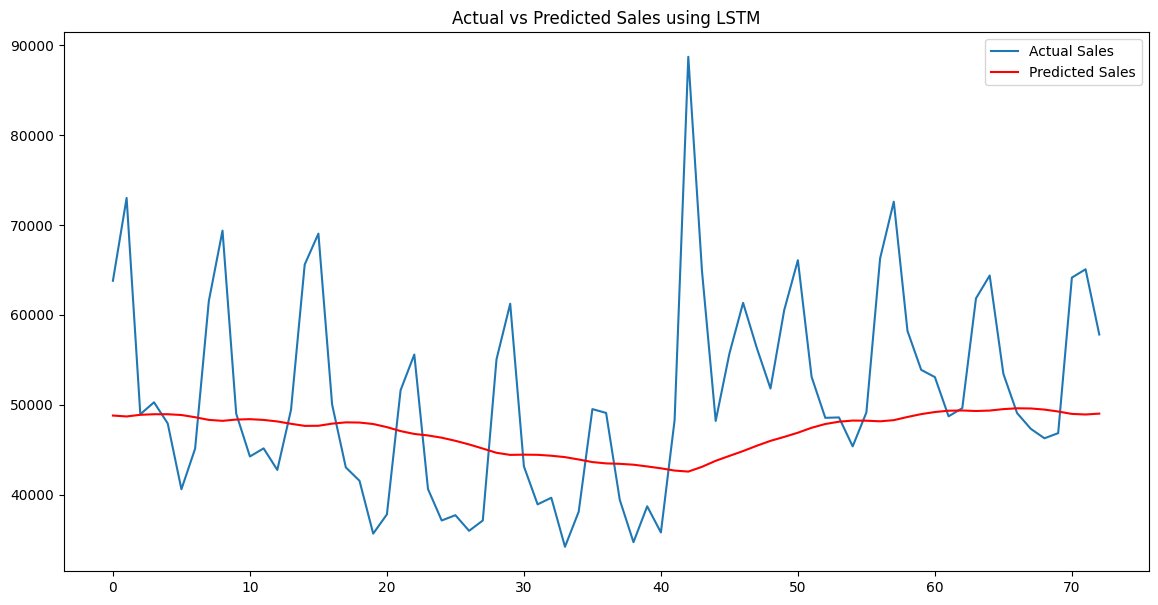

In [27]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

In [28]:
# Evaluation the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error

mse = mean_squared_error(y_test_scaled, predictions)
mae = mean_absolute_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)
rmae= mean_absolute_percentage_error(y_test_scaled, predictions)


print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'R-mean Absolute Percent Error: {rmae}')

Mean Squared Error: 134016894.64481919
Mean Absolute Error: 8636.747751712328
R-squared: -0.10829242544358753
R-mean Absolute Percent Error: 0.15822394670107412


# Conclusion:

1. Both MSE and MAE are highh, it means alarge gap between predicted and actual values.
2. r2 is negative, it means the model has no explanatory.
3. MAPE is 15.8%, the value needs to combine with other values.  

In [29]:
 # Log metrics
mlflow.log_metric("MSE", mse)
mlflow.log_metric("MAE", mae)
mlflow.log_metric("R2", r2)
mlflow.log_metric("MAPE", rmae)

In [30]:
# # Save model summary
with open("model_summary.txt", "w") as f:
  model.summary(print_fn=lambda x: f.write(x + "\n"))
mlflow.log_artifact("model_summary.txt")

# Hyperparameter tuning

In [ ]:
pip install scikit-learn==1.3.2 scipy==1.11.4 scikeras==0.12.0

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
#from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Prepare data with lagged features and scale it
scaler = MinMaxScaler()
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

# Reshape to 3D for LSTM
# Reshape X_train_scaled for LSTM
X_train_scaled= X_train_scaled.reshape(X_train_scaled.shape[0],X_train_scaled.shape[1],1)# reshape to 3D
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Define functions for LSTM model creation
def create_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001):
  model=Sequential()
  model.add(LSTM(units=units, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=1))
  model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error'])


  return model


In [ ]:
#set early stopping
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)# continuous 3 time, if result not improve, strop training and come back to the best weights



In [ ]:
# Wrap model for use with scikit-learn grid search
model=KerasRegressor(model=create_lstm_model,verbose=0,fit__callbacks=[early_stop])


In [ ]:
# Define parameter grid
param_grid={
    'model__units':[50,100], # the NN layes
    'model__dropout_rate':[0.1,0.2,0.3], # dropout is regulatorization tech and dropout 0.1-0.3 to avoid the overfitting
    'batch_size':[16,32,64], # the sample size of renew model, the small number produce the noise and large is stable but consume resourse
    'epochs':[50,100], # traing numbers
    'optimizer':['adam'],
    'model__learning_rate':[0.001,0.01] #control the renewing speed. the rate too big will drop out the smallest, the smallest the speed slowly
}

#Pefrom random size, and only choose 10 combination to evaluate

In [ ]:
# Perform random search, reduce the time of hyperparameter(is better than Fridsearch CV)
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error',
                                   n_jobs=-1,
                                   cv=3,
                                   error_score='raise')# easier to find the mistakes




In [ ]:
# Start to train
random_search.fit(X_train_scaled, y_train)
# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

ValueError: Could not interpret metric identifier: loss

In [ ]:
# Retrive the best parameterss
best_params_lstm=random_search.best_params_
print('Besr parameters for LSTM:',best_params_lstm)